# Coordinate Ascent Variational Inference for GMMs

In this notebook you'll practice deriving and implementing coordinate ascent variational inference (CAVI) for a model you now know and love, the Gaussian mixture model (GMM). Following Lecture 9, we will focus on the simple case in which the covariances are known for each mixture component, but we'll give some pointers at the end as to how you could generalize this approach.



## Generative model
Assume each mixture component has identity covariance. Then the generative model is,

1. Sample parameters for each mixture component:

$$
\begin{align*}
\mu_k &\sim \mathcal{N}(\nu^{-1} \phi, \nu^{-1} I) \\
\end{align*}
$$

2. Sample mixture weights,

$$
\begin{align*}
\pi &\sim \mathrm{Dir}(\alpha) 
\end{align*}
$$

3. Sample mixture assignments for each data point,

$$
\begin{align*}
z_n &\sim \mathrm{Cat}(\pi)
\end{align*}
$$

4. Sample data points given parameters and assignments,

$$
\begin{align*}
x_n &\sim \mathcal{N}(\mu_{z_n}, I)
\end{align*}
$$

As we showed in class, you can write the log joint probability as,

$$
\begin{align*}
&\log p(X, Z, \{\mu_k\}_{k=1}^K, \pi) = \\
&\hspace{4em} \sum_{n=1}^N \sum_{k=1}^K \left[ \mathbb{I}[z_n = k] \left(\log \mathcal{N}(x_n \mid \mu_k, I)  + \log \pi_k \right)  \right] \\
&\hspace{8em}  + \sum_{k=1}^K [\log \mathcal{N}(\mu_k \mid \nu^{-1} \phi , \nu^{-1} I)] + \log \mathrm{Dir}(\pi \mid \alpha) 
\end{align*}
$$

where we have used the shorthand $X = \{x_n\}_{n=1}^N$, $Z = \{z_n\}_{n=1}^N$. 


## Part 1: Derive the conditional distributions

To speed you along, we've given you the answers for this part. Double check that you understand how we arrived at them, then proceed to Part 1 where you'll derive the corresponding CAVI updates.

### Problem 1a: Conditional distribution of the mixture means
Derive $p(z_n \mid x_n, \pi, \{\mu_k\}_{k=1}^K)$

---

**Solution:** 

$$
\begin{align*}
p(z_n \mid x_n, \pi, \{\mu_k\}_{k=1}^K) 
&\propto p(z_n \mid \pi) p(x_n \mid \{\mu_k\}_{k=1}^K, z_n) \\
&\propto \pi_{z_n} \mathcal{N}(x_n \mid \mu_{z_n}, I)
\end{align*}
$$

Normalizing,

$$
\begin{align*}
p(z_n = k \mid x_n, \pi, \{\mu_k\}_{k=1}^K) 
&= \frac{\pi_{k} \mathcal{N}(x_n \mid \mu_k, I)}{\sum_{j=1}^K \pi_{j} \mathcal{N}(x_n \mid \mu_j, I)}
\triangleq \omega_{n,k}
\end{align*}
$$

---


### Problem 1b: Conditional distribution of the mixture weights
Derive $p(\pi \mid \{z_n\}_{n=1}^N, \alpha)$


---

**Solution:**

$$
\begin{align*}
p(\pi \mid \{z_n\}_{n=1}^N) 
&\propto p(\pi) \prod_{n=1}^N p(z_n \mid \pi) \\
&\propto \mathrm{Dir}(\pi \mid \alpha) \prod_{n=1}^N \prod_{k=1}^K \pi_k^{\mathbb{I}[z_n = k]} \\
&= \mathrm{Dir}(\pi \mid \widetilde{\alpha})
\end{align*}
$$

where

$$
\begin{align*}
\widetilde{\alpha}_k 
= \alpha_k + \sum_{n=1}^N \mathbb{I}[z_n = k]
\end{align*}
$$

---

### Problem 1c: Conditional distribution of the mixture means
Derive $p(\mu_k \mid \{x_n, z_n\}_{n=1}^N, 0, \nu^{-1} I)$


---

**Solution:** 

$$
\begin{align*}
p(\mu_k \mid \{x_n, z_n\}_{n=1}^N) 
&\propto p(\mu_k) \prod_{n=1}^N p(x_n \mid \mu_k)^{\mathbb{I}[z_n = k]} \\
&\propto \mathcal{N}(\mu_k \mid \nu^{-1} \phi, \nu^{-1} I) \prod_{n=1}^N \mathcal{N}(x_n \mid \mu_k, I)^{\mathbb{I}[z_n = k]} \\
&\propto \exp \left\{-\frac{\nu + N_k}{2} \mu_k^\top  \mu_k + \mu_k^\top \left(\phi + \sum_{n=1}^N \mathbb{I}[z_n = k] x_n \right) \right\} \\
&\propto \mathcal{N}\left(\mu_k \, \bigg| \, \widetilde{\nu}_k^{-1} \widetilde{\phi}_k, \, \widetilde{\nu}_k^{-1} I  \right)
\end{align*}
$$

where

$$
\begin{align*}
\widetilde{\phi}_k &= \phi + \sum_{n=1}^N \mathbb{I}[z_n = k] x_n \\
\widetilde{\nu}_k &= \nu + \sum_{n=1}^N \mathbb{I}[z_n = k]
\end{align*}
$$

---

## Part 2: Derive the CAVI updates
For the Gaussian mixture model we will use a mean field posterior approximation, which assumes that the parameters and latent variables are all independent:

$$
\begin{align*}
q(Z, \{\mu_k\}_{k=1}^K, \pi) &= \prod_{n=1}^N \left[q(z_n; \widetilde{\omega}_n) \right] \, \prod_{k=1}^K \left[q(\mu_k; \widetilde{\nu}_k, \widetilde{\phi}_k) \right] \, q(\pi; \widetilde{\alpha})
\end{align*}
$$

We will find the optimal variational approximation via coordinate ascent on the ELBO. Recall that the general form for a CAVI update is to set the mean field factor for one variable $q(\theta_j; \lambda_j)$ equal to,

$$
\begin{align*}
q(\theta_j; \lambda_j) \propto \exp \left\{\mathbb{E}_{q(\theta_{\neg j}; \lambda_{\neg j})}\left[ \log p(\theta_j \mid x, \theta_{\neg j}) \right] \right\}
\end{align*}
$$

or equivalently, 

$$
\begin{align*}
\log q(\theta_j; \lambda_j) &= \mathbb{E}_{q(\theta_{\neg j}; \lambda_{\neg j})}\left[ \log p(\theta_j \mid x, \theta_{\neg j}) \right] + c
\end{align*}
$$

For models like this one, which are built of exponential family distributions with conjugate priors, these CAVI updates will have simple closed form solutions.

In Problem 1, you already derived the conditional distributions. Now you just have to compute the expected log conditional densities, where the expectation is taken with respect to the other variables.

### Problem 2a: Derive the CAVI update for the mixture means

The mixture assignments are discrete variables $z_n \in \{1,\ldots,K\}$ so their variational posterior must be a discrete distribution; aka a categorical distribution:

$$
\begin{align*}
q(z_n; \widetilde{\omega}_n) &= \mathrm{Cat}(z_n ; \widetilde{\omega}_n)
\end{align*}
$$

where 

$$
\begin{align*}
\widetilde{\omega}_n = \left[ \widetilde{\omega}_{n,1}, \ldots, \widetilde{\omega}_{n,K} \right]^\top
\end{align*}
$$
are the variational parameters. They must be non-negative and sum to one. These are equivalent to the _responsibilities_ from Week 4. 

Derive an expression for $\widetilde{\omega}_{n,k}$ in terms of $\mathbb{E}_{q(\pi)}[\log \pi_k]$ and $\mathbb{E}_{q(\mu_k)}[\log \mathcal{N}(x_n \mid \mu_k, I)]$

---

**Solution:**
From Problem 1a,

$$
\begin{align*}
\log p(z_n \mid x_n, \pi, \{\mu_k\}_{k=1}^K) 
&= \log \pi_{z_n} + \log \mathcal{N}(x_n \mid \mu_{z_n}, I) + c
\end{align*}
$$

We need,

$$
\begin{align*}
\log q(z_n; \widetilde{\omega}_n) &= \mathbb{E}_{q(\pi)}[\log \pi_{z_n}] + \mathbb{E}_{q(\{\mu_k\}_{k=1}^K)}[\log \mathcal{N}(x_n \mid \mu_{z_n}, I)]+ c
\end{align*}
$$

We can write this equivalently as,

$$
\begin{align*}
\log q(z_n; \widetilde{\omega}_n) &= \sum_{k=1}^K \mathbb{I}[z_n = k] \left[ \mathbb{E}_{q(\pi)}[\log \pi_{k}] + \mathbb{E}_{q(\{\mu_k\}_{k=1}^K)}[\log \mathcal{N}(x_n \mid \mu_k, I)] \right] + c \\
&= \log \mathrm{Cat}(z_n \mid \widetilde{\omega}_n) 
\end{align*}
$$

where

$$
\begin{align*}
\widetilde{\omega}_{n,k} = \frac{\exp \left\{ \mathbb{E}_{q(\pi)}[\log \pi_{k}] + \mathbb{E}_{q(\{\mu_k\}_{k=1}^K)}[\log \mathcal{N}(x_n \mid \mu_k, I)] \right\}}{\sum_{j=1}^K \exp \left\{ \mathbb{E}_{q(\pi)}[\log \pi_{j}] + \mathbb{E}_{q(\{\mu_k\}_{k=1}^K)}[\log \mathcal{N}(x_n \mid \mu_j, I)] \right\}}
\end{align*}
$$

Put differently, the CAVI update is a categorical distribution with _logits_ 

$$
\begin{align*}
\mathbb{E}_{q(\pi)}[\log \pi_{k}] + \mathbb{E}_{q(\{\mu_k\}_{k=1}^K)}[\log \mathcal{N}(x_n \mid \mu_k, I)]
\end{align*}
$$

---

### Problem 2b: Derive the CAVI update for the mixture weights

Show that 

$$
\begin{align*}
q(\pi; \widetilde{\alpha}) = \mathrm{Dir}(\pi ; \widetilde{\alpha})
\end{align*}
$$

where $\widetilde{\alpha} \in \mathbb{R}_+^{K}$ is a vector of posterior concentrations. 

Derive the optimal update for the variational parameters $\widetilde{\alpha}$ in terms of $\alpha$ and $\widetilde{\omega}_{n,k}$, using the fact that

$$
\begin{align*}
\mathbb{E}_{q(z_n)}[\mathbb{I}[z_n = k]] &= \widetilde{\omega}_{n,k}.
\end{align*}
$$

---

**Solution:**
Following the same recipe as above,

$$
\begin{align*}
\log q(\pi; \widetilde{\alpha}) &= \mathbb{E}_{q(z)}[\log p(\pi \mid Z, \alpha)] \\
&= \log \mathrm{Dir}(\pi; \alpha) + \sum_{n=1}^N \mathbb{E}_{q(z)}[\log p(z_n \mid \pi)] + c \\
&= \sum_{k=1}^K \left(\alpha_k + \sum_{n=1}^N \mathbb{E}_{q(z_n)} \mathbb{I}[z_n = k] - 1 \right) \log \pi_k + c\\
&= \log \mathrm{Dir}(\pi; \widetilde{\alpha}) 
\end{align*}
$$

where

$$
\begin{align*}
\widetilde{\alpha}_k &= \alpha_k + \sum_{n=1}^N \mathbb{E}_{q(z_n)} \mathbb{I}[z_n = k] \\
&= \alpha_k + \sum_{n=1}^N \widetilde{\omega}_{n,k}.
\end{align*}
$$

---

### Problem 2c: Derive the CAVI updates for the mixture means

Show that the optimal $q(\mu_k; \widetilde{\nu}_k, \widetilde{\phi}_k)$ is a Gaussian distribution,

$$
\begin{align*}
q(\mu_k; \widetilde{\nu}_k, \widetilde{\phi}_k) = \mathcal{N}(\mu_k; \widetilde{\nu}_k^{-1} \widetilde{\phi}_k, \widetilde{\nu}_k^{-1} I)
\end{align*}
$$

---

**Solution**: 
Like above,

$$
\begin{align*}
\log q(\mu_k; \widetilde{\nu}_k, \widetilde{\phi}_k) &=
\mathbb{E}_{q(z)}[\log p(\mu_k \mid X, Z, \nu)] + c \\
&= \log \mathcal{N}(\mu_k; \nu^{-1} \phi, \nu^{-1}I) + \sum_{n=1}^N \mathbb{E}_{q(z_n)}[\mathbb{I}[z_n = k]] \log \mathcal{N}(x_n \mid \mu_k; I) \\
&= -\frac{\nu}{2} \mu_k^\top \mu_k  + \phi^\top \mu_k + \sum_{n=1}^N \mathbb{E}_{q(z_n)}[\mathbb{I}[z_n = k]] \left(-\frac{1}{2} \mu_k^\top \mu_k + x_n^\top \mu_k \right) + c\\
&= -\frac{\widetilde{\nu}_k}{2} \mu_k^\top \mu_k + \widetilde{\phi}_k^\top \mu_k \\
&= \log \mathcal{N} \left(\mu_k; \widetilde{\nu}_k^{-1} \widetilde{\phi}_k, \widetilde{\nu}_k^{-1} I \right) 
\end{align*}
$$

where

$$
\begin{align*}
\widetilde{\nu}_k &= \nu + \sum_{n=1}^N \widetilde{\omega}_{n,k} \\
\widetilde{\phi}_k &= \phi + \sum_{n=1}^N \widetilde{\omega}_{n,k} x_n
\end{align*}
$$

---

### Problem 2d: Derive the Gaussian cross entropy

The _negative cross entropy_ between $q(x)$ and $p(x)$ is defined as,

$$
\begin{align*}
\mathbb{E}_{q(x)}[\log p(x)]
\end{align*}
$$

Since $q(\mu_k)$ is Gaussian, and since $\mathcal{N}(x_n \mid \mu_k, I) = \mathcal{N}(\mu_k \mid x_n, I)$, we now recognize the $\mathbb{E}_{q(\mu_k)}[\log \mathcal{N}(x_n \mid \mu_k, I)]$ term in our $q(z)$ update as the negative cross entropy between two multivariate normal distributions.

Show that the negative cross entropy between two multivariate normal distributions is,

$$
\begin{align*}
\mathbb{E}_{\mathcal{N}(x \mid \mu_1, \Sigma_1)}[\log \mathcal{N}(x \mid \mu_2, \Sigma_2)] 
&= 
\log \mathcal{N}(\mu_1 \mid \mu_2, \Sigma_2) -\tfrac{1}{2} \mathrm{Tr}(\Sigma_1 \Sigma_2^{-1})
\end{align*}
$$

---

**Solution:**

$$
\begin{align*}
\mathbb{E}_{\mathcal{N}(x \mid \mu_1, \Sigma_1)}[\log \mathcal{N}(x \mid \mu_2, \Sigma_2)] 
&= \mathbb{E}_{\mathcal{N}(x \mid \mu_1, \Sigma_1)} \left[ -\frac{1}{2} \log 2\pi -\frac{1}{2} \log |\Sigma_2| - \frac{1}{2}(x - \mu_2)^\top \Sigma_2^{-1} (x - \mu_2) \right] \\
&= \mathbb{E}_{\mathcal{N}(x \mid \mu_1, \Sigma_1)} \left[ -\frac{1}{2} \log 2\pi -\frac{1}{2} \log |\Sigma_2| - \frac{1}{2}\langle x x^\top, \Sigma_2^{-1} \rangle + x^\top \Sigma_2^{-1} \mu_2 - \frac{1}{2} \mu_2^\top \Sigma_2^{-1} \mu_2 \right] \\
&= -\frac{1}{2} \log 2\pi -\frac{1}{2} \log |\Sigma_2| - \frac{1}{2}\langle \Sigma_1 + \mu_1 \mu_1^\top, \Sigma_2^{-1} \rangle + \mu_1^\top \Sigma_2^{-1} \mu_2 - \frac{1}{2} \mu_2^\top \Sigma_2^{-1} \mu_2 \\
&= -\frac{1}{2} \log 2\pi -\frac{1}{2} \log |\Sigma_2| - \frac{1}{2}  \mu_1^\top \Sigma_2^{-1} \mu_1 + \mu_1^\top \Sigma_2^{-1} \mu_2 - \frac{1}{2} \mu_2^\top \Sigma_2^{-1} \mu_2 + \langle \Sigma_1, \Sigma_2^{-1} \rangle \\
&= \log \mathcal{N}(\mu_1 \mid \mu_2, \Sigma_2) + \langle \Sigma_1, \Sigma_2^{-1} \rangle \\
&= \log \mathcal{N}(\mu_1 \mid \mu_2, \Sigma_2) + \mathrm{Tr}(\Sigma_1 \Sigma_2^{-1})
\end{align*}
$$

---

## Part 3: Derive the ELBO


### Problem 3a: Break the ELBO into parts
The ELBO is generically written as,
\begin{align}
\mathcal{L}(\lambda) &=
\mathbb{E}_q [\log p(X, Z, \{\mu_k\}_{k=1}^K, \pi) - \log q(Z, \{\mu_k\}_{k=1}^K, \pi) ]\end{align}
Rewrite the ELBO in terms of the following quantities,
- $\mathbb{E}_{q(z_n)}[\mathbb{I}[z_n = k]] \, \mathbb{E}_{q(\mu_k)}[\log \mathcal{N}(x_n \mid \mu_k, I)]$
- $\mathbb{E}_{q(\pi)} [\mathrm{KL}(q(z_n) \, \| \, \pi)]$
- $\mathrm{KL}(q(\pi) \, \| \, p(\pi))$
- $\mathrm{KL}(q(\mu_k) \, \| \, p(\mu_k))$

---

**Solution:**

$$
\begin{align*}
\mathcal{L}(\lambda) &=
\mathbb{E}_q [\log p(X, Z, \{\mu_k\}_{k=1}^K, \pi) - \log q(Z, \{\mu_k\}_{k=1}^K, \pi) ]\\
&= 
\mathbb{E}_q \left[\sum_{n=1}^N \sum_{k=1}^K \mathbb{I}[z_n=k] \left( \log\mathcal{N}(x_n \mid \mu_k, I) + \log \pi_k \right) + \log p(\pi) + \sum_{k=1}^K \log p(\mu_k) \right. \\
&\qquad \left. - \sum_{n=1}^N \log q(z_n) - \log q(\pi) - \sum_{k=1}^K \log q(\mu_k) \right] \\
&= 
\sum_{n=1}^N \sum_{k=1}^K \mathbb{E}_{q(z_n)} \mathbb{E}_{q(\mu_k)} \left[ \mathbb{I}[z_n=k] \log\mathcal{N}(x_n \mid \mu_k, I) \right] + \sum_{n=1}^N \mathbb{E}_{q(\pi)} \mathbb{E}_{q(z_n)}[ \log p(z_n \mid \pi) - \log q(z_n)]  + \mathbb{E}_{q(\pi)} [\log p(\pi) - \log q(\pi)] + \sum_{k=1}^K \mathbb{E}_{q(\mu_k)} [\log p(\mu_k) - \log q(\mu_k)] \\
&= 
\sum_{n=1}^N \sum_{k=1}^K \mathbb{E}_{q(z_n)} [\mathbb{I}[z_n=k]] \mathbb{E}_{q(\mu_k)} [\log\mathcal{N}(x_n \mid \mu_k, I)] + \sum_{n=1}^N \mathbb{E}_{q(\pi)} [\mathrm{KL}[q(z_n) \, \| \, p(z_n \mid \pi)] + \mathrm{KL}( q(\pi) \, \| \,  p(\pi)) + \sum_{k=1}^K \mathrm{KL}(q(\mu_k) \, \| \, p(\mu_k))
\end{align*}
$$

---

### Problem 3b: Derive closed form expressions for each term in the ELBO

Find closed form expressions for each term from Problem 3a.

---

**Solution:**

These are a bit tedious to type up. The first one follows from problem 2d. The last two are textbook KL divergences. The second is just a KL between two discrete distributions, but you need to use the expected value of $\log \pi_k$ under a Dirichlet distribution.

---

## Part 4: Implementation

In [1]:
import torch
from torch.distributions import Dirichlet, MultivariateNormal, Categorical
from torch.distributions.kl import kl_divergence

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from tqdm.auto import trange

In [2]:
#@title Helper function to draw ellipse
def confidence_ellipse(mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Modified from: https://matplotlib.org/3.5.0/gallery/\
        statistics/confidence_ellipse.html
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    mean: vector-like, shape (n,)
        Mean vector.
        
    cov : matrix-like, shape (n, n)
        Covariance matrix.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    # compute the 2D covariance ellipse
    pearson = cov[0, 1] / torch.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = torch.sqrt(1 + pearson)
    ell_radius_y = torch.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), 
                      width=ell_radius_x * 2, 
                      height=ell_radius_y * 2,
                      facecolor=facecolor, 
                      **kwargs)

    # Calculating the standard deviation
    # the square root of the variance and multiplying
    # with the given number of standard deviations.
    scale = torch.sqrt(torch.diag(cov) * n_std)
    
    # Transform the ellipse by rotating, scaling, and translating
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(*scale) \
        .translate(*mean)
    ellipse.set_transform(transf + ax.transData)

    # Add the patch to the axis
    return ax.add_patch(ellipse)

## Write some helper fucntions for KL divergences and cross entropies


In [3]:
def dirichlet_expected_log(dirichlet):
    """Helper function to compute expected log under Dirichlet distribution.

    Args:
        dirichlet: A torch.distributions.Dirichlet object with a batch shape of
            (...,) and a event shape of (K,).

    Returns:
        (...,K) tensor of expected logs, E[\log \pi], under the Dirichlet.
    """
    concentration = dirichlet.concentration
    return torch.special.digamma(concentration) - \
           torch.special.digamma(concentration.sum(dim=-1, keepdims=True))


def dirichlet_log_normalizer(concentration):
    """Compute the log normalizing constant of a Dirichlet distribution with
    the specificed concentration.

    Args:
        concentration: (...,K) tensor of concentration parameters

    Returns:
        (...,) batch of log normalizers
    """
    return torch.special.gammaln(concentration).sum(dim=-1) - \
        torch.special.gammaln(concentration.sum(dim=-1))


def gaussian_neg_cross_entropy(q, p):
    """Compute the negative cross entropy between two Gaussian distributions,
        
        -E_{q(x | \mu_q, \Sigma_q)}[\log p(x | \mu_p, \Sigma_p)]

    Args:
        q: A torch.distributions.MultivariateNormal object
        p: A torch.distributions.MultivariateNormal object

    Returns:
        A (batch of) cross entropy(ies) between q and p.
    """
    mu_q = q.mean
    Sigma_q = q.covariance_matrix
    mu_p = p.mean
    Sigma_p = p.covariance_matrix

    # Compute the multivariate normal cross entropy
    return p.log_prob(mu_q) - 0.5 * torch.diagonal(
        torch.linalg.solve(Sigma_p, Sigma_q), dim1=-2, dim2=-1).sum(dim=-1)

In [4]:
# #@title Test our implementations against tensorflow probability
# import jax.numpy as jnp
# from tensorflow_probability.substrates import jax as tfp
# tfd = tfp.distributions

# # Code to suppress stupid TFP warnings
# import logging
# logger = logging.getLogger()
# class CheckTypesFilter(logging.Filter):
#     def filter(self, record):
#         return "check_types" not in record.getMessage()
# logger.addFilter(CheckTypesFilter())

# # Test Gaussian cross entropy
# p = MultivariateNormal(torch.zeros(2), torch.eye(2))
# q = MultivariateNormal(torch.ones(2), 2 * torch.eye(2))
# print("my ce:  ", gaussian_neg_cross_entropy(q, p).numpy())
# p2 = tfd.MultivariateNormalFullCovariance(jnp.zeros(2), jnp.eye(2))
# q2 = tfd.MultivariateNormalFullCovariance(jnp.ones(2), 2 * jnp.eye(2))
# print("tfp ce: ", -q2.cross_entropy(p2))

### Problem 4a: Implement CAVI updates


In [5]:
def cavi_step_z(data, q_pi, q_theta):
    """
    Perform a CAVI update of q(z) given the data, q(\pi), and q(\{\mu_k\}_{k=1}^K)

    Args:
        data: (N, D) tensor where each row is a data point
        q_pi: td.Dirichlet posterior distribution over the mixture weights
        q_theta: td.MultivariateNormal posterior distribution over the set of
            mixture means. I.e. `q_theta.mean.shape == (K, D)` and 
            `q_theta.covariance_matrix.shape == (K, D, D)` where K is the 
            number of mixture components.

    Returns:
        q_z: a Categorical distribution over a batch of N mixture assignments.
    """
    E_logpi = dirichlet_expected_log(q_pi)  # (K,)
    E_loglkhd = gaussian_neg_cross_entropy(
        MultivariateNormal(q_theta.mean.unsqueeze(0), 
                           q_theta.covariance_matrix.unsqueeze(0)),
        MultivariateNormal(data.unsqueeze(1), torch.eye(data.shape[-1]))) # (N, K)
    
    return Categorical(logits=E_logpi + E_loglkhd)
    

def cavi_step_pi(q_z, alpha):
    """
    Performa CAVI update of q(\pi) given q(z) and alpha.

    Args:
        q_z: Categorical posterior distribution over mixture assignments
        alpha: scalar (or shape (K,) tensor of) prior concentration(s)

    Returns:
        q_pi: Dirichlet posterior distribution over mixture weights
    """
    return Dirichlet(alpha + q_z.probs.sum(axis=0))


def cavi_step_mu(data, q_z, nu, phi):
    """
    Performa CAVI update of q(\mu) given q(z) and prior hyperparameters.

    Args:
        q_z: Categorical posterior distribution over mixture assignments
        nu:  prior precision (scalar)
        phi: prior precision-weighted-mean (scalar or (D,))

    Returns:
        q_pi: Dirichlet posterior distribution over mixture weights
    """
    dim = data.shape[-1]
    E_z = q_z.probs
    phi_tilde = phi + (data.unsqueeze(1) * E_z.unsqueeze(2)).sum(0)    # (K, D)
    nu_tilde = nu + E_z.sum(0)                                         # (K,)

    mu = phi_tilde / nu_tilde.unsqueeze(1)
    Sigma =  1 / nu_tilde[:, None, None] * torch.eye(dim)
    return MultivariateNormal(mu, Sigma)
    

### Problem 4b: Implement the ELBO

In [6]:
def elbo(data, q_z, q_pi, q_mu, alpha, nu, phi):
    """Compute the evidence lower bound.
    """
    E_z = q_z.probs
    N, D = data.shape
    K = q_pi.concentration.shape[-1]

    # E_q[\log p(x | z, \{\mu_k\}_{k=1}^K)]
    E_loglkhd = gaussian_neg_cross_entropy(
        MultivariateNormal(q_mu.mean.unsqueeze(0), 
                           q_mu.covariance_matrix.unsqueeze(0)),
        MultivariateNormal(data.unsqueeze(1), torch.eye(D)))
    
    elbo = torch.sum(E_z * E_loglkhd)
    
    # E_q(z)q(pi)[\log p(z | \pi)]
    elbo += torch.sum(E_z * dirichlet_expected_log(q_pi))

    # -E_q[\log q(z)]
    elbo -= torch.sum(E_z * q_z.logits)

    # KL to prior
    elbo -= kl_divergence(q_pi, Dirichlet(alpha * torch.ones(K)))
    elbo -= torch.sum(kl_divergence(
        q_mu, MultivariateNormal(1/nu * phi * torch.ones(D), 1/nu * torch.eye(D))))
    return elbo

### Put it all together

In [9]:
def cavi(data, 
         num_components=2, 
         num_iter=100, 
         tol=1e-5, 
         alpha=20.0, 
         nu=1.0,
         phi=0.0,
         seed=305 + ord('c'),
        ):
    """Run coordinate ascent VI for the Gaussian Mixture Model.
    
    """
    data = data.type(torch.float)
    N, D = data.shape
    K = num_components      # short hand
    
    # Initialize the clusters randomly
    torch.manual_seed(seed)
    clusters = Categorical(logits=torch.zeros(K)).sample((N,))
    q_pi = Dirichlet(alpha * torch.ones(K))
    q_mu = MultivariateNormal(
        torch.row_stack([data[clusters == k].mean(axis=0) for k in range(K)]),
        torch.eye(D).repeat(K, 1, 1))
    q_z = Categorical(logits=torch.zeros((N, K)))
    
    # Run CAVI
    elbos = [elbo(data, q_z, q_pi, q_mu, alpha, nu, phi)]
    for itr in trange(num_iter):
        # Update variational factors one at a time
        q_z = cavi_step_z(data, q_pi, q_mu)
        q_pi = cavi_step_pi(q_z, alpha)
        q_mu = cavi_step_mu(data, q_z, nu, phi)
        
        # Compute the ELBO
        elbos.append(elbo(data, q_z, q_pi, q_mu, alpha, nu, phi))
        
        # Check for convergence
        if elbos[-1] - elbos[-2] < -1e-4:
            raise Exception("ELBO is going down!")
        elif elbos[-1] - elbos[-2] < tol:
            print("Converged!")
            break
        
    return torch.tensor(elbos), (q_z, q_pi, q_mu)
        

### Test on synthetic data

  0%|          | 0/100 [00:00<?, ?it/s]

Converged!
Cluster  0 :
	 E[mu_k]:    tensor([7.3993, 7.4017])
	 Cov[mu_k]:  tensor([[0.0407, 0.0000],
        [0.0000, 0.0407]])
	 E[pi_k]:    tensor(0.3899)

Cluster  1 :
	 E[mu_k]:    tensor([4.4907, 4.1577])
	 Cov[mu_k]:  tensor([[0.0522, 0.0000],
        [0.0000, 0.0522]])
	 E[pi_k]:    tensor(0.3040)

Cluster  2 :
	 E[mu_k]:    tensor([1.2618, 1.6898])
	 Cov[mu_k]:  tensor([[0.0519, 0.0000],
        [0.0000, 0.0519]])
	 E[pi_k]:    tensor(0.3061)



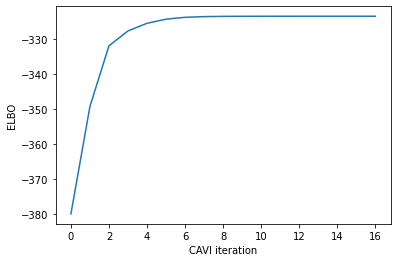

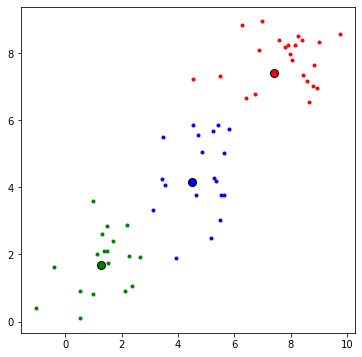

In [10]:
# Generate synthetic data points   
torch.manual_seed(305 + ord('c'))
K = 3
D = 2
N = 60
true_thetas = torch.Tensor([[2, 2], [5, 5], [8, 8]])
X = MultivariateNormal(
    true_thetas, torch.eye(D)).sample((N // K,)).reshape(-1, D)

# Run the CAVI algorithm
elbos, (q_z, q_pi, q_mu) = \
    cavi(X, 
         num_components=K, 
         alpha=torch.ones(K),
         nu=1.0)
    
# Print the results  
for k in range(K):
    print("Cluster ", k, ":")
    print("\t E[mu_k]:   ", q_mu.mean[k,:])
    print("\t Cov[mu_k]: ", q_mu.covariance_matrix[k,:,:])
    print("\t E[pi_k]:   ", q_pi.mean[k])
    print("")

# Plot the log probabilities over EM iterations
plt.figure()
plt.plot(elbos[1:])
plt.xlabel("CAVI iteration")
plt.ylabel("ELBO")

# create a second figure to plot the clustered data
fig, ax = plt.subplots(figsize=(6, 6))

# plot scatter 
colors = ["red", "blue", "green"]
z_hat = torch.argmax(q_z.probs, 1)

for k in range(K):
    ax.plot(X[z_hat==k, 0], X[z_hat==k, 1], c=colors[k], ls='', marker='.')
    ax.plot(q_mu.mean[k, 0], q_mu.mean[k, 1], c=colors[k], 
            mec='k', marker='o', ms=8)


## Conclusion

Truth be told, I spent about an hour debugging my CAVI implementation until I found a ridiculously simple bug! The code was still returning sensible results, but the ELBO was going down. I thought for sure it was a bug in my ELBO calculation (because that's where it usually is), but this time it was in my update for $q(\mu_k)$. In the end, I guess checking if the ELBO decreased was a useful debugging tool!